In [16]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from models import LSTMModel, attentional_LSTM
import random
import optuna
from torch.utils.data import DataLoader, TensorDataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(42)

In [3]:
df = yf.download('NVDA', start='2015-01-01', end='2025-01-01')
df


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2015-01-02,0.483144,0.486744,0.475463,0.483144,113680000
2015-01-05,0.474983,0.484584,0.472823,0.483144,197952000
2015-01-06,0.460582,0.476183,0.460102,0.475703,197764000
2015-01-07,0.459382,0.468023,0.457942,0.463943,321808000
2015-01-08,0.476663,0.479543,0.464423,0.464663,283780000
...,...,...,...,...,...
2024-12-24,140.220001,141.899994,138.649994,140.000000,105157000
2024-12-26,139.929993,140.850006,137.729996,139.699997,116205600


In [4]:
data = df[['Close']].values
min(data),  max(data)



(array([0.4593823]), array([148.86975098]))

In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length]) #overlapping seqs
        y.append(data[i+seq_length]) #next day close as target 

    X ,y = np.array(X), np.array(y)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

seq_length = 60  
X, y = create_sequences(data_scaled, seq_length)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = X_train.view(-1, seq_length, 1)
X_test = X_test.view(-1, seq_length, 1)

In [6]:
len(X), y

(2456,
 tensor([[3.0252e-04],
         [3.1550e-04],
         [3.2362e-04],
         ...,
         [9.2009e-01],
         [9.2332e-01],
         [9.0176e-01]]))

In [7]:
def train(model, criterion, X, y, epochs=50, device='cpu'):

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    model.to(device)
    X, y= X.to(device), y.to(device)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        outputs = model(X_train)
        loss = criterion(outputs, y_train.view(-1, 1))

        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")

    return model


def eval(model,X_test, y_test, device=device ):
    model.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    model.eval()
    with torch.no_grad():
        predictions = model(X_test).cpu().numpy()
        actual = y_test.cpu().numpy()

    return predictions, actual

In [8]:
criterion = nn.MSELoss()


In [44]:

model = LSTMModel().to(device)


trained_LSTM= train(model, criterion,
                            X_train, y_train, epochs=250, device=device)
LSTM_predictions, actual = eval(trained_LSTM,X_test, y_test)


Epoch [10/250], Loss: 0.004983
Epoch [20/250], Loss: 0.002819
Epoch [30/250], Loss: 0.002360
Epoch [40/250], Loss: 0.002303
Epoch [50/250], Loss: 0.002134
Epoch [60/250], Loss: 0.001804
Epoch [70/250], Loss: 0.000817
Epoch [80/250], Loss: 0.000144
Epoch [90/250], Loss: 0.000077
Epoch [100/250], Loss: 0.000054
Epoch [110/250], Loss: 0.000047
Epoch [120/250], Loss: 0.000042
Epoch [130/250], Loss: 0.000040
Epoch [140/250], Loss: 0.000038
Epoch [150/250], Loss: 0.000036
Epoch [160/250], Loss: 0.000036
Epoch [170/250], Loss: 0.000035
Epoch [180/250], Loss: 0.000034
Epoch [190/250], Loss: 0.000034
Epoch [200/250], Loss: 0.000033
Epoch [210/250], Loss: 0.000033
Epoch [220/250], Loss: 0.000033
Epoch [230/250], Loss: 0.000033
Epoch [240/250], Loss: 0.000032
Epoch [250/250], Loss: 0.000032


* Bidirectional LSTM (Bi-LSTM) → Captures both past and future context.
* Attention Mechanism 
* Hybrid Models (LSTM + ARIMA) 
* feats : Volume, Moving Averages (SMA, EMA), RSI, MACD (Technical Indicators), "News Sentiment Data"

In [45]:
print(LSTMModel.__init__.__code__.co_varnames)


('self', 'input_size', 'hidden_size', 'num_layers', 'output_size', 'bidirectional', 'fc_input_size')


In [46]:
Bi_LSTM = LSTMModel(input_size=1, hidden_size=64, num_layers=2, output_size=1,bidirectional=True)

trained_Bi_LSTM= train(Bi_LSTM, criterion, 
                            X_train, y_train, epochs=250, device=device)


Epoch [10/250], Loss: 0.002578
Epoch [20/250], Loss: 0.002494
Epoch [30/250], Loss: 0.002292
Epoch [40/250], Loss: 0.001957
Epoch [50/250], Loss: 0.001156
Epoch [60/250], Loss: 0.000488
Epoch [70/250], Loss: 0.000193
Epoch [80/250], Loss: 0.000046
Epoch [90/250], Loss: 0.000034
Epoch [100/250], Loss: 0.000034
Epoch [110/250], Loss: 0.000030
Epoch [120/250], Loss: 0.000026
Epoch [130/250], Loss: 0.000025
Epoch [140/250], Loss: 0.000025
Epoch [150/250], Loss: 0.000024
Epoch [160/250], Loss: 0.000024
Epoch [170/250], Loss: 0.000023
Epoch [180/250], Loss: 0.000023
Epoch [190/250], Loss: 0.000023
Epoch [200/250], Loss: 0.000022
Epoch [210/250], Loss: 0.000022
Epoch [220/250], Loss: 0.000022
Epoch [230/250], Loss: 0.000021
Epoch [240/250], Loss: 0.000021
Epoch [250/250], Loss: 0.000021


In [47]:
Bi_LSTM_predictions, actual = eval(trained_Bi_LSTM,X_test, y_test)

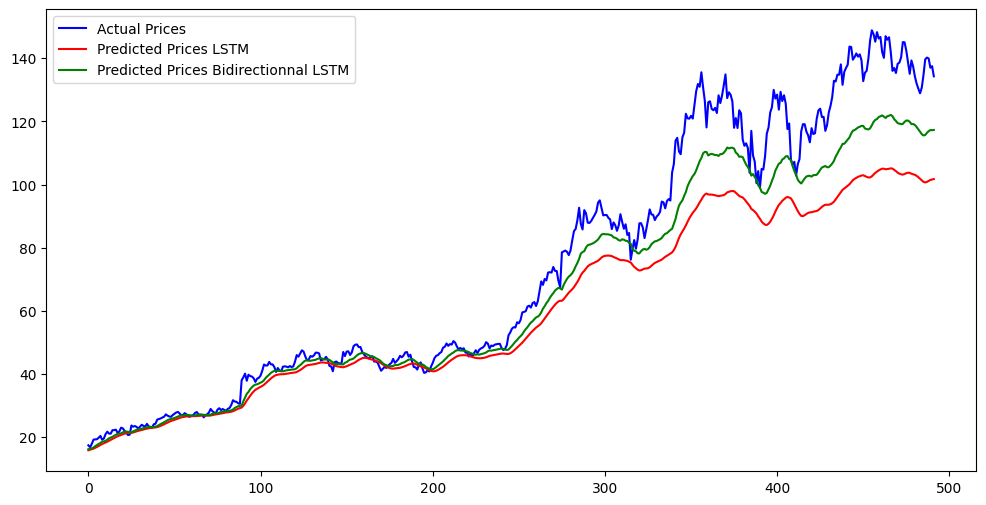

In [48]:
#back to og scale
LSTM_predictions = scaler.inverse_transform(LSTM_predictions)
Bi_LSTM_predictions= scaler.inverse_transform(Bi_LSTM_predictions)
actual = scaler.inverse_transform(actual.reshape(-1, 1))

plt.figure(figsize=(12,6))
plt.plot(actual, label="Actual Prices", color='blue')
plt.plot(LSTM_predictions, label="Predicted Prices LSTM", color='red')
plt.plot(Bi_LSTM_predictions, label="Predicted Prices Bidirectionnal LSTM", color='green')


plt.plot()
plt.legend()
plt.show()

### attention mechanisms(time-wise) on LSTM : 
* Instead of just using the last hidden state, Attention learns to assign weights to different time steps based on their relevance and then compute weighted sum of all hidden states

In [10]:
model = attentional_LSTM(input_size=1, hidden_size=128, num_layers=3, output_size=1,attention_size= 64, bidirectional=True).to(device)


trained_model = train(model, criterion, 
                            X_train, y_train, 
                            epochs=250, device=device)



Epoch [10/250], Loss: 0.002499
Epoch [20/250], Loss: 0.002549
Epoch [30/250], Loss: 0.002182
Epoch [40/250], Loss: 0.000494
Epoch [50/250], Loss: 0.000328
Epoch [60/250], Loss: 0.000140
Epoch [70/250], Loss: 0.000128
Epoch [80/250], Loss: 0.000128
Epoch [90/250], Loss: 0.000122
Epoch [100/250], Loss: 0.000117
Epoch [110/250], Loss: 0.000112
Epoch [120/250], Loss: 0.000104
Epoch [130/250], Loss: 0.000089
Epoch [140/250], Loss: 0.000075
Epoch [150/250], Loss: 0.000064
Epoch [160/250], Loss: 0.000058
Epoch [170/250], Loss: 0.000056
Epoch [180/250], Loss: 0.000054
Epoch [190/250], Loss: 0.000051
Epoch [200/250], Loss: 0.000056
Epoch [210/250], Loss: 0.000051
Epoch [220/250], Loss: 0.000050
Epoch [230/250], Loss: 0.000046
Epoch [240/250], Loss: 0.000036
Epoch [250/250], Loss: 0.000031


In [11]:
attentional_LSTM_predictions, actual= eval(trained_model ,X_test, y_test)

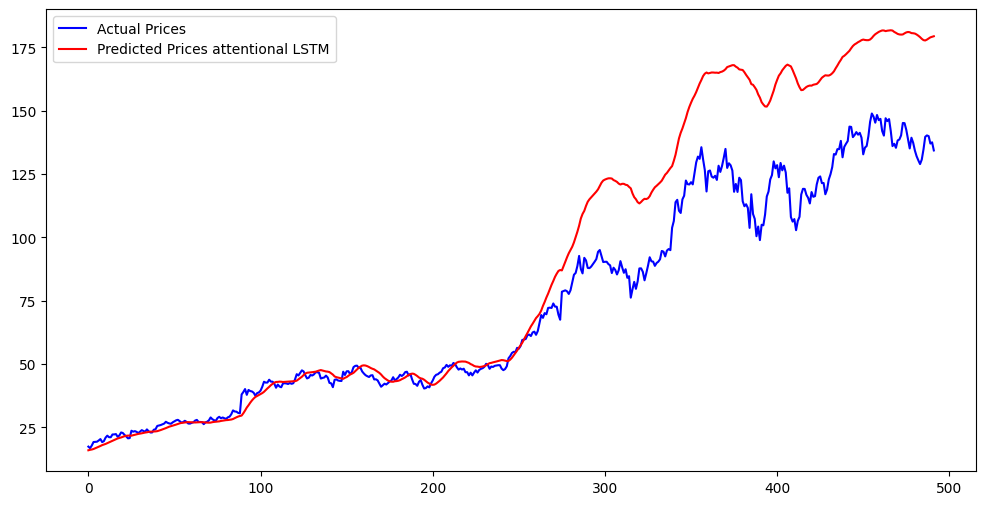

In [12]:

attentional_LSTM_predictions= scaler.inverse_transform(attentional_LSTM_predictions)
actual = scaler.inverse_transform(actual.reshape(-1, 1))

plt.figure(figsize=(12,6))
plt.plot(actual, label="Actual Prices", color='blue')
plt.plot(attentional_LSTM_predictions, label="Predicted Prices attentional LSTM", color='red')

plt.plot()
plt.legend()
plt.show()

In [13]:
i=0
model_save_path = f"attentional_LSTM_model_{i}.pth"
i=+1
torch.save({
    'model_state_dict': model.state_dict(),
    'hyperparameters': {
        'input_size': 1,
        'hidden_size': 128,
        'num_layers': 3,
        'output_size': 1,
        'bidirectional': True,
        'attention_size': 64,
        'optimizer': 'Adam',
        'learning_rate': 0.001,
        'epochs': 2500
    }
}, model_save_path)


In [19]:
def objective(trial):
    hidden_size = trial.suggest_categorical("hidden_size", [32, 64, 128, 256])
    num_layers = trial.suggest_int("num_layers", 1, 4)
    attention_size = trial.suggest_categorical("attention_size", [8, 16, 32, 64])
    bidirectional = trial.suggest_categorical("bidirectional", [True, False])
    # learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = trial.suggest_categorical("epochs", [50, 100, 200])

    # DataLoader for batching
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = attentional_LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, 
                             output_size=1, attention_size=attention_size, bidirectional=bidirectional)
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.view(-1, 1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.6f}")

    # Evaluation
    predictions, actual = eval(model, X_test, y_test, device)
    mse = nn.MSELoss()(torch.tensor(predictions), torch.tensor(actual))

    return mse.item()  


In [20]:
study = optuna.create_study(direction="minimize")  # We want to minimize MSE
study.optimize(objective, n_trials=30) 

print("Best hyperparameters:", study.best_params)

[I 2025-02-15 18:46:30,770] A new study created in memory with name: no-name-3799e34c-18a1-45e1-8c45-90587bdf2ad8


Epoch 10/50, Loss: 0.000020


[W 2025-02-15 18:49:48,896] Trial 0 failed with parameters: {'hidden_size': 256, 'num_layers': 3, 'attention_size': 32, 'bidirectional': True, 'learning_rate': 0.0010494713479549916, 'batch_size': 16, 'epochs': 50} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/grace/miniconda3/envs/tf/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/cw/0t2jzw0d1dg1rj3qj57z9_qh0000gn/T/ipykernel_39585/2683035344.py", line 31, in objective
    loss.backward()
  File "/Users/grace/miniconda3/envs/tf/lib/python3.10/site-packages/torch/_tensor.py", line 492, in backward
    torch.autograd.backward(
  File "/Users/grace/miniconda3/envs/tf/lib/python3.10/site-packages/torch/autograd/__init__.py", line 251, in backward
    Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
KeyboardInterrupt
[W 2025-02-15 18:49:48,898] Trial 0

KeyboardInterrupt: 

#### Transformer Models for Time Series:

&rarr; Temporal Fusion Transformer (TFT)

&rarr; Informer: Sparse Attention Transformer

&rarr; DeepAR + Transformers

In [1]:
!pip install pytorch-forecasting


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 27.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
